Programa que, a partir de un conjunto de archivos .tim (uno por cada conjunto de S/N)
calcula el error sistemático que, sumado a los errores de los TOAs, resulta en un cálculo
de residuos con un chi²~1. Luego, calcula el RMS correspondiente a ese ajuste.
Adicionalmente, también grafica los valores obtenidos de sigma_sist y RMS en función de S/N,
junto a sus barras de error con un intervalo de confianza de 1 sigma.

In [ ]:
import numpy as np

import decimal
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.mlab as mlab
import matplotlib as mpl
import subprocess
import math
import scipy.stats

import os
import shutil

import libstempo as t2

In [52]:
#-------------------------------------------------------------------------------------------------
# pequeña funcion que nos servira mas adelante para saber por cuanto debemos multiplicar
# el paso para poder obtener un numero entero que ingresar en el for
#-------------------------------------------------------------------------------------------------

def num_after_point(x):
    s = str(x)
    if not '.' in s:
        return 0
    return len(s) - s.index('.') - 1

In [53]:
#-------------------------------------------------------------------------------------------------
# funcion que, dado un sigma sistematico, encuentra el chi cuadrado del grafico de residuos  
#-------------------------------------------------------------------------------------------------

def chissq_red(sigma_s):

# creamos un nuevo archivo .tim en el cual guardamos los puntos que no fueron descartador por
# outliers y en el cuales los errores aparecen aumentados según el sigma_s

    timing_folder = './results_sn_' + ant + '/timing_' + str(sn) + '/'   # nombre de la carpeta correspondiente al valor de S/N indicado
    timfile = "data_" + str(sigma_s) + ".tim"     # nombre del nuevo archivo .tim
    resfile = "residues_" + str(sigma_s) + ".dat" # nombre del archivo que contendrá el chi cuadrado
    
    f = open(timing_folder + timfile, "w+")       # abrimos el nuevo archivo .tim
    print("FORMAT 1" , file = f)                  # escibimos la primera linea

    vetar = True                                  # especificamos si deseamos usar un criterio de veto o no
    no_vet = 0                                    # número de observaciones no vetadas
    vet = 0                                       # número de obseraciones vetadas
                    
# ingresamos los datos, con el error aumentado en una cantidad igual a sigma sistematico

    if vetar:    # en caso que usemos un criterio de veto

        for j in range(len(res)):        # barremos todas las observaciones+
        
            if abs( res[j] * 10**6 ) < 3 * math.sqrt( (sigma_cero)**2 + error[j]**2 ):  # filtramos los outliers
        
                newerror = math.sqrt( (error[j])**2 + (sigma_s)**2 )   # calculamos el nuevo error
                print( str(file[j]) + ' ' + '{:11.6f}'.format(freq[j]) + ' ' + str(MJD[j]) + '   ' + '{:5.3f}'.format(newerror) + '  ' + str(telescope[j]), file = f)
                no_vet += 1
            
            else:
            
                vet += 1
                
    else:        # en caso de que no usemos un criterio de veto
        
            for j in range(len(res)):        # barremos todas las observaciones
            
                newerror = math.sqrt( (error[j])**2 + (sigma_s)**2 )   # calculamos el nuevo error
                print( str(file[j]) + ' ' + '{:11.6f}'.format(freq[j]) + ' ' + str(MJD[j]) + '   ' + '{:5.3f}'.format(newerror) + '  ' + str(telescope[j]), file = f)
                vet += 0
    
    f.close()    # cerramos el archivo de salida
    
# llamamos a tempo2
    
    subprocess.check_call( "tempo2 >" + resfile + " -us -f J0437-4715.par " + timfile, cwd=timing_folder, shell = True)
    
# abrimos el archivo generado por tempo2, donde se encuentra el chicuadrado que buscamos

    chi_sqr_red = np.genfromtxt ( timing_folder + resfile, comments="none", dtype=float, skip_header=19, max_rows=1, usecols=(8) )

# devolvemos la informacion al programa principal

    return chi_sqr_red, no_vet

In [54]:
#-------------------------------------------------------------------------------------------------
# Función que halla el valor de sigma sistemático que da el chisq_red más cercano al valor deseado
#-------------------------------------------------------------------------------------------------

def best_fit(chi_buscado, xmin, xmax, step, tol, sigma_cero):

# Chequeamos los datos de entrada

    a = num_after_point(step)               # número de decimales en el paso
    xmin_int = int( xmin * (10 ** a) )      # límite inferior entero del intervalo
    xmax_int = int( xmax * (10 ** a) )      # límite superior entero del intervalo
    step_int = int( step * (10 ** a) )      # paso entero

    n = int( (xmax_int-xmin_int)/step_int ) # numero de subintervalos

# creamos un array para que guarde los sigma sistematicos de prueba y otro para los chi_sqr

    trial_sigma = np.empty(n)   # arreglo en el cual guardaremos los valores probados de sigma_sist
    chi_sqr = np.empty(n)       # arreglo en el cual guardaremos los valos de chisq_red obtenidos
    
# calculamos el valor de sigma sistemático 

    while step > tol:     # Iteramos hasta haber calculado sigma con el número de dígitos deseado

        i = 0
        for x in range(xmin_int, xmax_int, step_int):

            sigma_s = float(x)/ (10. ** a)      # sigma sistematico 

# vamos guardando el valor probado de sigma_s y el valor obtenido de chi_sqr en los arrays

            trial_sigma[i] = sigma_s
            chi_sqr[i], no_vet = chissq_red(sigma_s)
            
#            print( str(trial_sigma[i]) + ' ' + str(chi_sqr[i]) )          # si queremos escribir por pantalla  
            
            i += 1
        
# Creamos un nuevo array que sea la diferencia entre los chi_sqr obtenidos y el valor de chi dado
# y buscamos el chi cuadrado más cercano al dado y el correspondiente sigma

        diff_chi_sqr = abs ( chi_sqr - chi_buscado )          # creamos un array que sea la diferencia entre los chi calculados y el chi dado
        closer_chi = chi_sqr[ np.argmin(diff_chi_sqr)]        # hallamos el chi cuadrado más cercano al dado
        closer_sigma = trial_sigma[ np.argmin(diff_chi_sqr) ] # hallamos el correspondiente sigma 
    
# creamos un nuevo intervalo más acotado donde buscar el sigma sistematico
        
        if closer_chi < chi_buscado:                          # nos fijamos si nos pasamos del valor buscado
            xmax = closer_sigma
            xmin = closer_sigma - step
        elif closer_chi > chi_buscado:                        # o si estamos por debado
            xmax = closer_sigma + step
            xmin = closer_sigma
        else:
            return closer_sigma                               # o si justo caimos en el valor buscado
    
        step = step / 10.0                                    # reducimos el tamaño del paso
    
        a = num_after_point(step)           # número de decimales en el paso
        xmin_int = int( xmin * (10 ** a) )  # límite inferior entero del intervalo
        xmax_int = int( xmax * (10 ** a) )  # límite superior entero del intervalo
        step_int = int( step * (10 ** a) )  # queremos un paso entero

        n = int( (xmax_int-xmin_int)/step_int ) # numero de subintervalos

# para el nuevo intervalo, creamos un array para que guarde los sigma sistematicos de prueba y otro para los chi_sqr

        trial_sigma.resize(n)
        chi_sqr.resize(n)
    
    return closer_sigma, no_vet

In [55]:
#------------------------------------------------------------------------
# función que, de entre todos los archivos. dat generados,
# busca el correspondiente al valor de sigma pedido y de allí saca el RMS
#------------------------------------------------------------------------

def buscar_rms(sigma): 

    residue_file = './results_sn_A1/timing_' + sn + '/residues_' + str( sigma ) + '.dat'

    RMS = np.genfromtxt ( residue_file, comments="none", dtype=float, skip_header=18, max_rows=1, usecols=(10) )
    
    return RMS

In [56]:
# Estos son los datos de entrada

ant = 'A1'        # antena usada (A1 o A2)
xmin = 0.0        # cota inferior del intervalo dentro del cual se buscará el sigma_sist
xmax = 1.0        # cota superior del intervalo dentro del cual se buscará el sigma_sist
step = 0.1        # Paso utilizado para calcular el sigma sistemático
tol = 0.0001      # Precisión buscada en el valor del sigma sistemático
sigma_cero = 0.4  # Error sistemático inicial usado para vetar outliers

In [57]:
# Estos son unos arrays que después usaremos para graficar

sn_array = np.zeros(6)
sigma_sist_max = np.zeros(6)
sigma_sist_min = np.zeros(6)
sigma_sist = np.zeros(6)
rms = np.zeros(6)
rms_max = np.zeros(6)
rms_min = np.zeros(6)

In [ ]:
print("S/N  Sigma_s  RMS      N_free chisq_min chisq_max sigma_max sigma_min RMS_max RMS_min")

# Barremos todos los conjuntos

i=0
for y in [1, 50, 80, 110, 140, 170]:
    
    sn_array[i] = y
    
    if y == 1:
        sn = 'total'
    else:
        sn = str(y)
        
# creamos carpetas para guardar resultados

    os.chdir('./results_sn_' + ant + '/')
    if not os.path.exists('./timing_' + str(sn)):
        os.mkdir('./timing_' + str(sn))
    os.chdir('..')
    
    shutil.copy('./J0437-4715.par', './results_sn_' + ant + '/timing_' + str(sn) + '/')     # copiamos el archivo .par a la nueva carpeta para poder usar tempo2
        
# leemos los errores en los TOAs del archivo .tim generado por pat

    timfile = "./results_sn_" + ant + "/timing_files/timing_" + str(sn) + ".tim"    # nombre del archivo .tim original

    file = np.loadtxt( timfile , skiprows=1 , dtype=str , usecols=(0) )             # nombre de cada observación
    freq = np.loadtxt( timfile, skiprows=1, dtype=float , usecols=(1) )             # frecuencia de la observación
    MJD = np.loadtxt( timfile , skiprows=1 , dtype=decimal.Decimal , usecols=(2) )  # fecha juliana modificada de la observación
    error = np.loadtxt( timfile , skiprows=1 , dtype=float,  usecols=(3) )          # error en el TOA
    telescope = np.loadtxt( timfile, skiprows=1, dtype=str, usecols=(4) )           # antena usada (A1 o A2)

# calculamos los residuos de las observaciones

    psr = t2.tempopulsar(parfile = "./results_sn_" + ant + "/timing_files/J0437-4715.par", timfile = timfile)   # cargamos el archivo .par y el archivo .tim
    res = psr.residuals()                                                                # calculamos los residuos usando tempo2

# buscamos el sigma_sist que de el valor de chisq_red más cercano a 1

    sigma_sist[i], no_vet = best_fit(1.0, xmin, xmax, step, tol, sigma_cero)
    
# buscamos los valores de chisq_red que se corresponden a una confianza de 1 sigma

    prob_84 = scipy.stats.chi2.ppf( 0.84, no_vet)
    prob_16 = scipy.stats.chi2.ppf( 0.16, no_vet)
    
    chisq_red_norm_max = round(prob_84 / no_vet , 4)   # chisq_red + 1 sigma
    chisq_red_norm_min = round(prob_16 / no_vet , 4)   # chisq_red - 1 sigma
    
# calculamos las barras de error del valor obtenido de sigma
    
    sigma_sist_min[i], no_vet1 = best_fit(chisq_red_norm_max, xmin, xmax, step, tol, sigma_cero)
    sigma_sist_max[i], no_vet2 = best_fit(chisq_red_norm_min, xmin, xmax, step, tol, sigma_cero)
    
# buscamos el rms resultante de calcular residuos sumando el sigma_sist hallado a los errores de los TOAs

    rms[i] = buscar_rms(sigma_sist[i])
    
# calculamos las barras de error del valor obtenido de RMS    
    
    rms_max[i] = round(math.sqrt( ((no_vet) / prob_16 )) * rms[i]  , 4)
    rms_min[i] = round(math.sqrt( ((no_vet) / prob_84 )) * rms[i]  , 4) 

# imprimimos los resultados por pantalla
   
    print(str(y) + "   " + str(sigma_sist[i]) + "     " + str(rms[i]) + "     " + str(no_vet) + "     " + str(chisq_red_norm_min) + "      " + str(chisq_red_norm_max) + "      " + str(sigma_sist_max[i]) + "      " + str(sigma_sist_min[i]) + "      " + str(rms_max[i]) + "    " + str(rms_min[i]))
    
    i += 1            # aumentamos en 1 el índice usado para los arreglos

S/N  Sigma_s  RMS      N_free chisq_min chisq_max sigma_max sigma_min RMS_max RMS_min
1   0.549     0.603     96     0.8569      1.143      0.607      0.503      0.6514    0.564


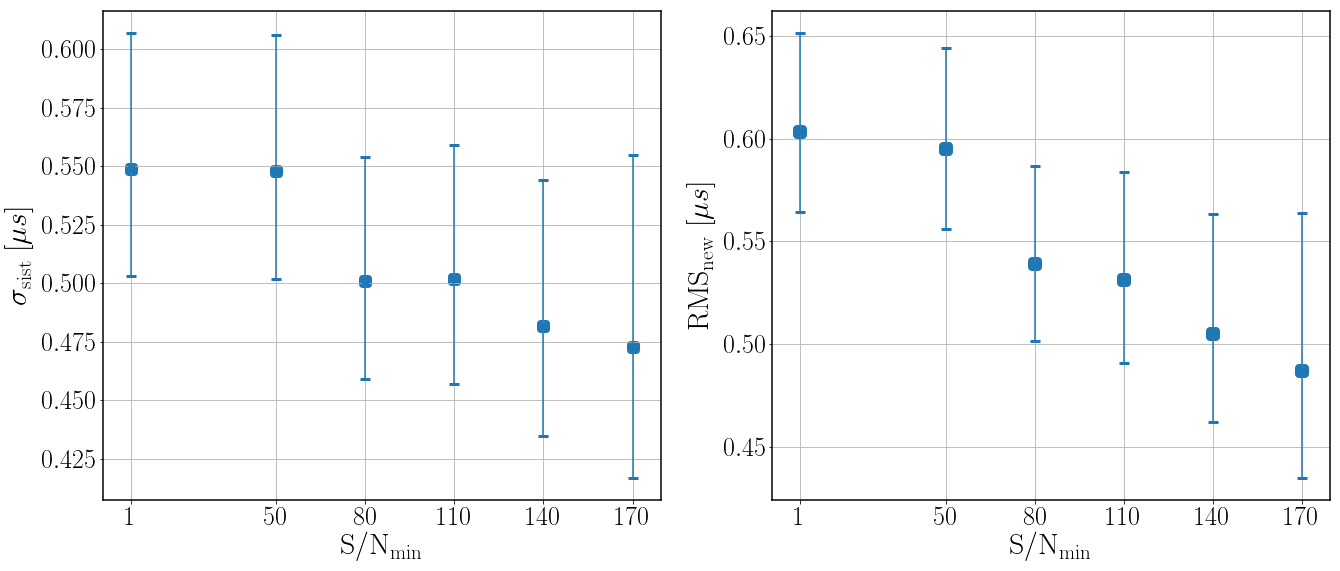

In [50]:
# Estos son los parámetros que usaremos para graficar

nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 30,
        "font.size": 28,
        "axes.linewidth": 1.5,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 32,
        "xtick.labelsize": 26,
        "ytick.labelsize": 26,
}
# Update the fonts
mpl.rcParams.update(nice_fonts)
#plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,9))

ax1.set(xlabel='S/N_{\mathrm{min}}', ylabel="$ \sigma_{\mathrm{sist}}~[\mu s]$")
ax2.set(xlabel='S/N_{\mathrm{min}}', ylabel="$ {\mathrm{RMS_{new}}}~[\mu s] $")
ax1.grid()
ax2.grid()

plt.setp(ax1, xticks=[1,50,80,110,140,170])
plt.setp(ax2, xticks=[1,50,80,110,140,170])

# graficamos los resultados

asymmetric_error_sigma = [abs(sigma_sist_min-sigma_sist), abs(sigma_sist_max-sigma_sist)]  # calculamos las barras de error del sigma
asymmetric_error_rms = [abs(rms_min-rms), abs(rms_max-rms)]            # calculamos las barras de error de la RMS

ax1.scatter(sn_array, sigma_sist, label='', marker="s", lw=7)
ax1.errorbar(sn_array, sigma_sist, yerr=asymmetric_error_sigma, label='', marker="s", fmt='o', capthick=3, capsize=5)
#ax1.legend()

ax2.scatter(sn_array, rms, label='', marker="s", lw=8)
ax2.errorbar(sn_array, rms, yerr=asymmetric_error_rms, label='', marker="s", fmt='o', capthick=3, capsize=5)
#ax2.legend()

plt.show()